# Curso de Python feito pela FEA.Dev à USP
Uma breve análise dos alunos a partir das informações fornecidas por eles no formulário de interesse. 


<p align='center'>
    <img src ='https://www.techrepublic.com/wp-content/uploads/2022/12/tra-python-3-courses-121422-770x385.png'>
</p>

In [17]:
# Importação das bibliotecas necessárias

import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from unidecode import unidecode

## **Parte feita pelo Gustavo Yuji — Tratamento dos dados**

In [22]:
# Formulário de interesse

df = pd.read_csv(r'C:\Users\ana_c\OneDrive\Documentos\GitHub\Random\Manifestação_de_Interesse_Curso_de_Python_2022.csv', decimal = ',')

pd.set_option('display.max_columns', None)
df = pd.read_csv(r'C:\Users\ana_c\OneDrive\Documentos\GitHub\Random\Manifestação_de_Interesse_Curso_de_Python_2022.csv', decimal = ',')

In [23]:
# Utilizar apenas colunas interessantes

df = df.iloc[:, [1,2,3,4,10,11,12,13,14,15,16,17,21,37,38,39]]
df.columns = ['Idade', 'Genero', 'Ano de ingresso','Aluno USP', 'Nível de graduação', 'Instituto', 'Curso', 'Período', 'Vida profissional', 'Conhecimento prog', 'Conhecimento Py', 'Outras linguagens', 'Formato preferido', 'Nome', 'Nusp', 'e-mail'] 

In [24]:
# Remover duplicadas

df.drop_duplicates(subset = ['e-mail'], keep = 'last', inplace = True) 

In [25]:
# Transformar os institutos em valores únicos

df['Instituto'] = df['Instituto'].apply(lambda x: str(x).upper().strip().replace('USP', "").replace('/', '').replace('-',''))

for antigo, novo in {"FCF ( FACULDADE DE CIÊNCIAS FARMACÊUTICAS )":'FCF', 'INSTITUTO DE BIOCIÊNCIAS (IB)': 'IB'}.items():
    df['Instituto'] = df['Instituto'].replace(antigo, novo)

In [26]:
# Padronizar os anos de ingresso

for antigo, novo in {'21':'2021', '16':'2016', '17':'2017', '021':'2021', '2013/2022':'2013', '20':'2020'}.items():
    df['Ano de ingresso'] = df['Ano de ingresso'].replace(antigo, novo)

In [27]:
# Casos que podem indicar que a pessoa não sabe outra linguagem
# Substituindo esses casos por 'não'

teste = df.dropna(subset = ['Outras linguagens'])
teste = teste[(teste['Outras linguagens'].str.startswith('n')) | 
      (teste['Outras linguagens'].str.contains('Ainda', case = False)) |
      (teste['Outras linguagens'].str.startswith('N'))]['Outras linguagens'].unique().tolist()

df['Outras linguagens'].fillna("Não", inplace = True)

df['Outras linguagens'] = np.where(df['Outras linguagens'].isin(teste), "Não", "Sim")

In [28]:
# Remoção das sujeiras da coluna idade

df['Idade'] = pd.to_numeric(df['Idade'], errors='coerce')
df['Idade'] = df['Idade'].fillna(df['Idade'].mode()[0])
df['Idade'].replace({2014:df['Idade'].mode()[0], 900:df['Idade'].mode()[0],
                            1:df['Idade'].mode()[0]}, inplace=True)

In [29]:
# Padronização da coluna de graduação

df['Nível de graduação'].replace({'pos-doutorado':'Pós-Doutorado', 'Doutorado ':'Doutorado', 
                                        'Sou funcionária do Setor de Arquivo do Instituto de Biociências da USP.':'Funcionário',
                                        'Funcionário/aluna pós':'Funcionário', 'Doutorado direto ':'Doutorado'}, inplace=True)

In [30]:
# Ano para inteiro

df['Ano de ingresso'] = df['Ano de ingresso'].astype(int)

## **Parte feita pela Ana C. Santos — Visualização dos dados**

In [33]:
# Colunas do df para escolher as mais interessantes

df.columns

Index(['Idade', 'Genero', 'Ano de ingresso', 'Aluno USP', 'Nível de graduação',
       'Instituto', 'Curso', 'Período', 'Vida profissional',
       'Conhecimento prog', 'Conhecimento Py', 'Outras linguagens',
       'Formato preferido', 'Nome', 'Nusp', 'e-mail'],
      dtype='object')

In [145]:
# Criar um df com a quantidade de alunos em cada instituto
# Visualizar os institutos não feanos com pelo menos cinco alunos interessados

df_instituto = pd.DataFrame(df.groupby(['Instituto']).size())
df_instituto.reset_index(inplace = True)
df_instituto.columns = ['Instituto', 'Qtd Aluno']
drop_fea = df_instituto[(df_instituto['Instituto'] == 'FEA')].index
drop_nan = df_instituto[(df_instituto['Instituto'] == 'NAN')].index
drop_five = df_instituto[(df_instituto['Qtd Aluno'] < 5)].index
df_instituto.drop(drop_fea, inplace = True)
df_instituto.drop(drop_nan, inplace = True)
df_instituto.drop(drop_five, inplace = True)
df_instituto.sort_values('Qtd Aluno', ascending = False)

,Instituto,Qtd Aluno
3,ECA,115
32,IME,110
17,FFLCH,100
25,IB,83
11,FCF,50
38,POLI,28
2,EACH,10
34,IQ,8
26,ICB,7
39,SANFRAN,7


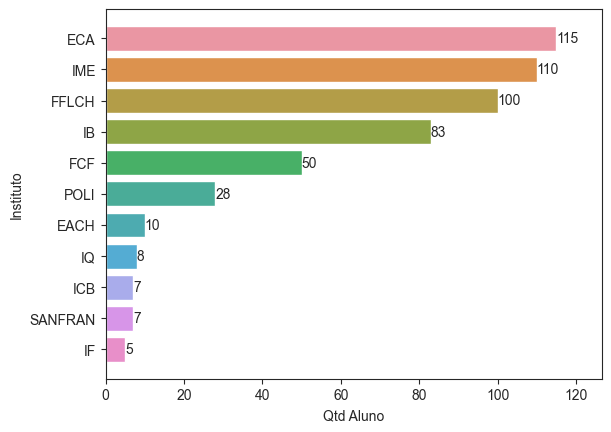

In [177]:
sns.set_style('ticks')

institutos = sns.barplot(x = df_instituto['Qtd Aluno'], 
                         y = df_instituto['Instituto'], 
                         data = df_instituto, 
                         order = df_instituto.sort_values('Qtd Aluno', ascending = False).Instituto)

institutos.bar_label(institutos.containers[0])
institutos.margins(x = 0.1, y = 0.05)

-- Decidir depois o que fazer c os códigos abaixo --

In [39]:
def grafico_pizza(df, coluna):
   """
   Passa o dataframe e a coluna desejada para fazer a pizza, mêoo
   """
   df = df
   data = list(df[coluna].value_counts())
   keys = list(df[coluna].dropna().unique())
   palette_color = sns.color_palette('pastel')

   plt.pie(data, labels=keys,autopct='%1.1f%%', startangle=0, colors=palette_color) 
   plt.show()

In [22]:
def agrupar(df, coluna, trigger):
    """
    Agrupa valores menos representativos na categoria "Outros"
    Nível de representatividade dado pelo trigger
    Retorna um dicionário contendo as novas proporções
    """
    dic = dict(df[coluna].value_counts())
    newdic = {}

    # Agrupar institutos com menos de 3% de representatividade em 'Outros'
    for key, group in itertools.groupby(dic, lambda k: 'Outros' if (dic[k]<(trigger*df[coluna].count())) else k):
        newdic[key] = sum([dic[k] for k in list(group)])
        
    return newdic

##### Representatividade por gênero

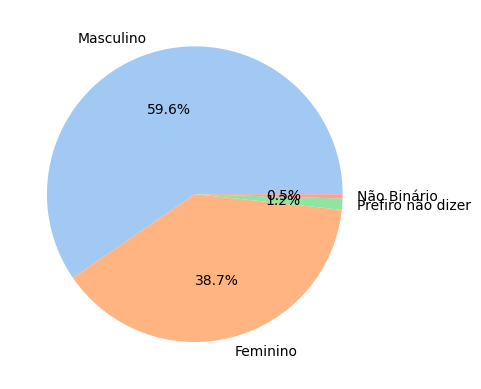

In [21]:
grafico_pizza(df, 'Genero')

In [24]:
df.head()

,Idade,Genero,Ano de ingresso,Aluno USP,Nível de graduação,Instituto,Curso,Período,Vida profissional,Conhecimento prog,Conhecimento Py,Outras linguagens,Formato preferido,Nome,Nusp,e-mail
0,19.0,Masculino,2021,Sim,Graduação,FEA,ADMINISTRAÇÃO,Diurno,Estou em busca de um estágio,4,4,Sim,Híbrido,Felipe Wendling Heidenfelder,12513450,felipewheidenfelder@gmail.com
1,26.0,Feminino,2017,Sim,Graduação,FCF,FARMÁCIA,Noturno,Já estou estagiando/trabalhando,2,3,Sim,Online,Zaira Maria de Sousa Pinheiro,10321470,zairapinheiro12@usp.br
2,25.0,Feminino,2018,Sim,Graduação,FCF,FARMÁCIA,Noturno,Já estou estagiando/trabalhando,1,1,Não,Online,Beatriz Ribeiro da Silva,10758690,b.ribeiro@usp.br
3,25.0,Feminino,2016,Sim,Graduação,FCF,FARMÁCIA,Noturno,Já estou estagiando/trabalhando,2,1,Não,Online,Janaina Novais,9819722,janaina.novais@usp.br
5,24.0,Masculino,2021,Sim,Graduação,FCF,FARMÁCIA,Noturno,Estou em busca de um estágio,1,1,Não,Presencial,Gabriel Batista de Souza,11322181,gabriel_souza@usp.br


##### Representatividade por instituto

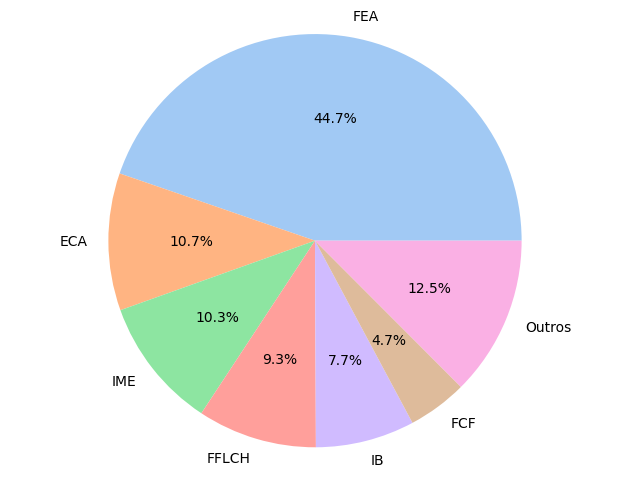

In [26]:
labels = list(agrupar(df, 'Instituto', 0.03).keys())
sizes = list(agrupar(df, 'Instituto', 0.03).values())
palette_color = sns.color_palette('pastel')

fig, ax = plt.subplots()

ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=0, colors=palette_color)
ax.axis('equal')
plt.tight_layout()

plt.show()

#### Período dos alunos

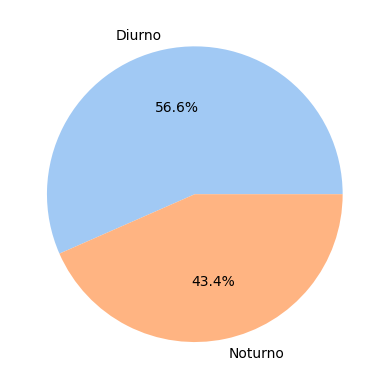

In [40]:
grafico_pizza(df, 'Período')

#### Idade do pessoal

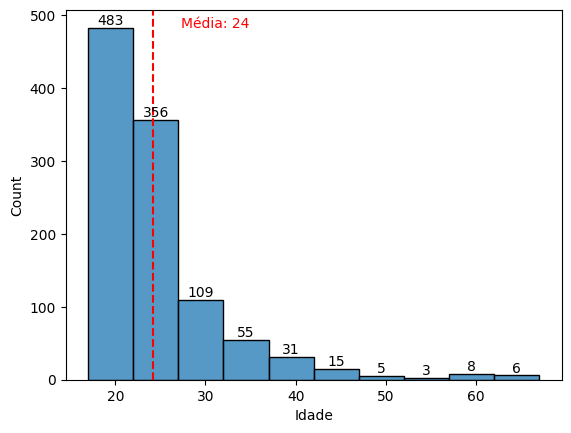

In [28]:
ax = sns.histplot(df, x='Idade', stat='count', binwidth=5)

for container in ax.containers:
    ax.bar_label(container)

plt.axvline(x=df.Idade.mean(), color='red', label='Média', ls='--')

plt.text(x = df['Idade'].mean()+3,
         y = max([h.get_height() for h in ax.patches]),
         s = 'Média: {:.0f}'.format(df['Idade'].mean()), 
 color = 'red')

plt.show()

#### Cursos

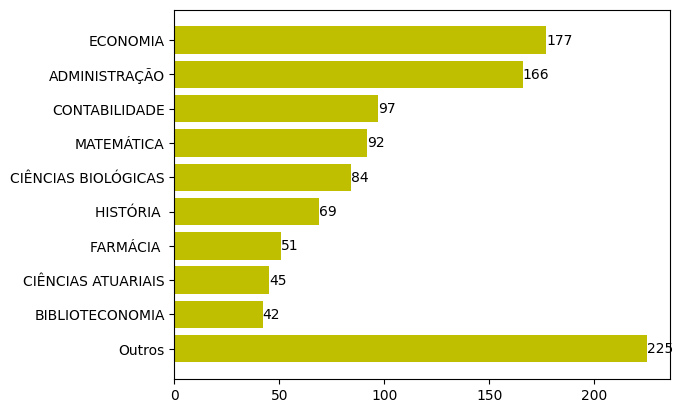

In [29]:
nomes = list(agrupar(df, 'Curso', trigger=0.02).keys())
valores = list(agrupar(df, 'Curso', trigger=0.02).values())

fig, ax = plt.subplots()

ax.barh(range(len(nomes)), valores, tick_label=nomes, color='y')
ax.invert_yaxis()

for container in ax.containers:
    ax.bar_label(container)

plt.show()

#### Graduação

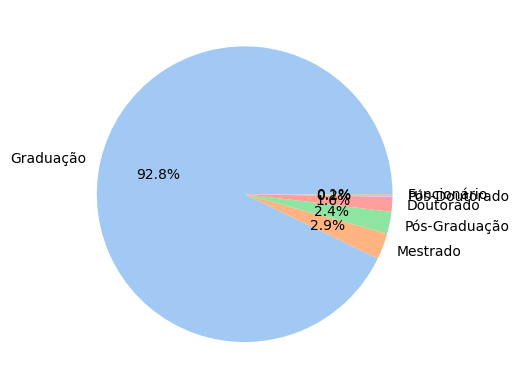

In [41]:
grafico_pizza(df, 'Nível de graduação')

# Dar um jeito nesse emaranhado de legendas